# Earth

In [3]:
!pip install -U -q netcdf4 xarray pytype google-cloud-storage pyresample

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/Public/goes_truecolor')

Mounted at /content/gdrive


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import netCDF4  # netCDF4 *must* be imported before tensorflow
import numpy as np
import logging
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import tensorflow as tf
from tensorflow import keras
import time
import urllib
import xarray

import google.cloud.storage as gcs

from goes_truecolor.lib import goes_reader

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

TRAIN_PATH = 'gs://weather-datasets/goes_truecolor/examples/train.tfrecord*'
TEST_PATH = 'gs://weather-datasets/goes_truecolor/examples/test.tfrecord*'

reader = goes_reader.GoesReader(
    project_id=PROJECT_ID,
    goes_bucket_name=GOES_BUCKET,
    shape=(1024, 1024))

In [5]:
def default_hparams(**kwargs: Any) -> tf.contrib.training.HParams:
  """Create default hyper-parameters for training a model.

  Args:
    **kwargs: default hyper-parameter values to override.

  Returns:
    HParams object with all hyperparameter values.
  """
  hparams = tf.contrib.training.HParams(
      model_dir='gs://weather-datasets/model',
      train_data_path=TRAIN_PATH,
      eval_data_path=TEST_PATH,
      train_batch_size=32,
      learning_rate=1e-3,
      train_steps=10000,
      num_eval_records=128,
      num_cores=8,
      tile_size=64,
      
      # CNN
      kernel_size=5,
      num_filters=16,
      num_layers=3,
  )
  hparams.override_from_dict(kwargs)
  return hparams

hparams = default_hparams()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [91]:
def load_model(hparams: tf.contrib.training.HParams) -> keras.Model:
  dirnames = tf.gfile.Glob(os.path.join(hparams.model_dir, 'export/exporter/[0-9]*'))
  model_file = sorted(dirnames)[-1]
  tf.logging.info('Loading model from %s', model_file)
  model = tf.contrib.saved_model.load_keras_model(model_file)
  model.summary()
  return model

model = load_model(hparams)

INFO:tensorflow:Loading model from gs://weather-datasets/model/export/exporter/1557943804


INFO:tensorflow:Loading model from gs://weather-datasets/model/export/exporter/1557943804


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 9)         0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 64, 64, 9)         36        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        3616      
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        6416      
_________________________________________________________________
activation_5 (Activation)    (None, 64, 64, 16)        0         
__________

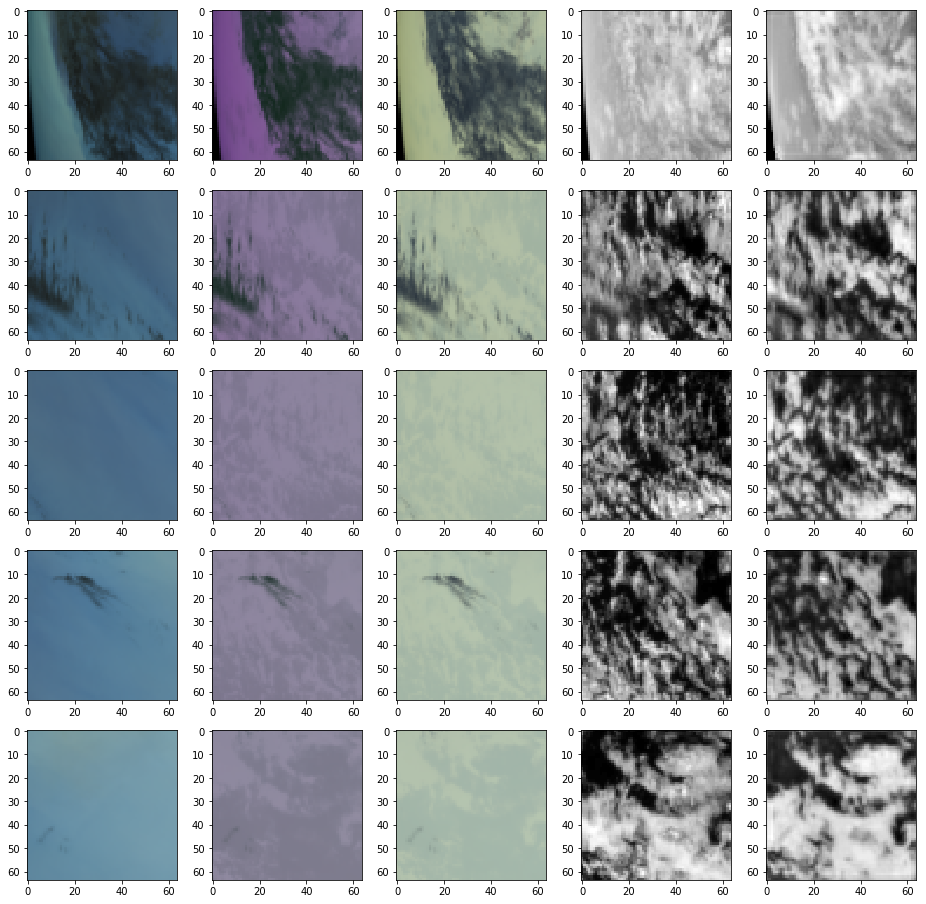

In [92]:
def show_prediction_tiles(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  cloud_mask_img = reader.cloud_mask(t)
  h, w = cloud_mask_img.shape
  tile_size = hparams.tile_size
  raster_out_img = np.split(cloud_mask_img[512:512 + tile_size, :], w // tile_size, axis=1)
  raster_out_img = np.array(raster_out_img)
  
  img, _ = reader.raw_image(t, goes_reader.IR_CHANNELS)
  img = img.astype(np.float32) / 256

  raster_in_img = np.split(img[512:512 + tile_size, :, :], w // tile_size, axis=1)
  raster_in_img = np.array(raster_in_img)
  predict_out_img = model.predict(raster_in_img)
  
  plt.figure(figsize=(16, 16))
  for i in range(5):
    for j in range(3):
      ax = plt.subplot(5, 5, i * 5 + j + 1)
      ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
    ax = plt.subplot(5, 5, i * 5 + 4)
    ax.imshow(raster_out_img[i, :, :], cmap='gray')
    ax = plt.subplot(5, 5, i * 5 + 5)
    ax.imshow(predict_out_img[i, :, :, 0], cmap='gray')
    
show_prediction_tiles(datetime.datetime(2019, 1, 1, 17), hparams)

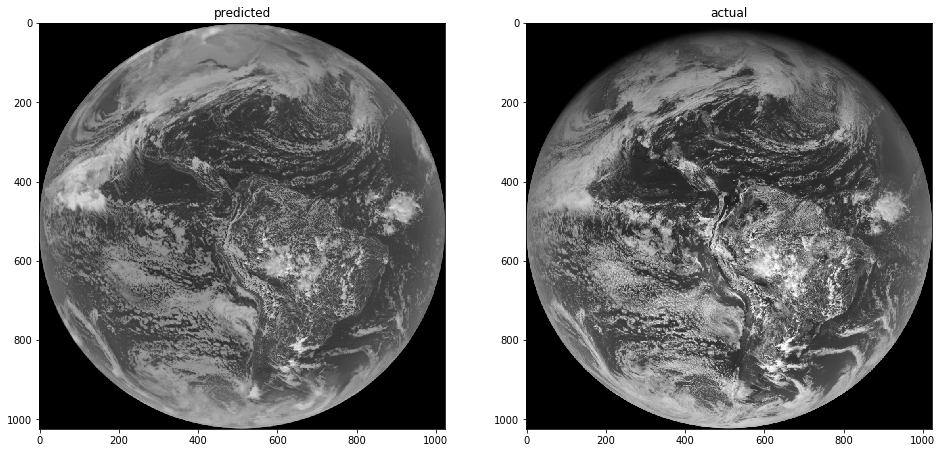

In [93]:
TILE_BORDER = 8

def get_overlapping_tiles(img: np.ndarray, tile_size: int, tile_border_size: int) -> List[List[np.ndarray]]:
  h, _, _ = img.shape
  inner_tile_size = tile_size - 2 * tile_border_size
  num_tiles = (h + inner_tile_size - 1) // inner_tile_size
  new_h = num_tiles * inner_tile_size + 2 * tile_border_size
  pad_l = tile_border_size
  pad_r = new_h - tile_border_size - h
  img = np.pad(img, ((pad_l, pad_r), (pad_l, pad_r), (0, 0)), 'constant')
  cols = []
  for x in range(0, new_h - tile_size + 1, inner_tile_size):
    rows = []
    for y in range(0, new_h - tile_size + 1, inner_tile_size):
      rows.append(img[y:y+tile_size, x:x+tile_size, :])
    cols.append(rows)
  return cols    

def predict_image(t: datetime.datetime, hparams: tf.contrib.training.HParams) -> Tuple[np.ndarray, Dict[Text, Any]]:
  tile_size = hparams.tile_size
  raster_in_img, md = reader.raw_image(t, goes_reader.IR_CHANNELS)
  raster_in_img = raster_in_img.astype(np.float32) / 256
  h, w, _ = raster_in_img.shape
  raster_in_tiles = get_overlapping_tiles(raster_in_img, tile_size, TILE_BORDER)

  # Assemble the prediction.
  predict_cols = []
  for raster_in_col in raster_in_tiles:
    raster_in_col = np.array(raster_in_col)
    predict_col = model.predict(raster_in_col)    
    tiles = [predict_col[b, TILE_BORDER:-TILE_BORDER, TILE_BORDER:-TILE_BORDER, :]
             for b in range(predict_col.shape[0])]    
    predict_col = np.concatenate(tiles, axis=0)
    predict_cols.append(predict_col)
  predict_img = np.concatenate(predict_cols, axis=1)
  predict_img = predict_img[:h, :w, 0]  
  return predict_img, md

def show_prediction_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  raster_out_img = reader.cloud_mask(t)
  predict_img, _ = predict_image(t, hparams)
 
  plt.figure(figsize=(16, 16))
  ax = plt.subplot(121)
  ax.imshow(predict_img, cmap='gray')
  plt.title('predicted')
  
  ax = plt.subplot(122)
  ax.imshow(raster_out_img, cmap='gray')
  plt.title('actual')
  plt.show()
    
show_prediction_image(datetime.datetime(2019, 1, 1, 17), hparams)

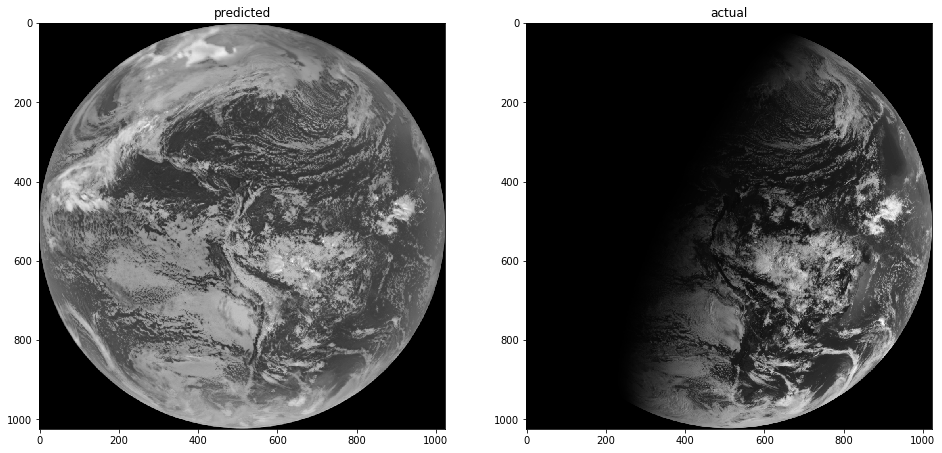

In [94]:
show_prediction_image(datetime.datetime(2019, 1, 1, 12), hparams)

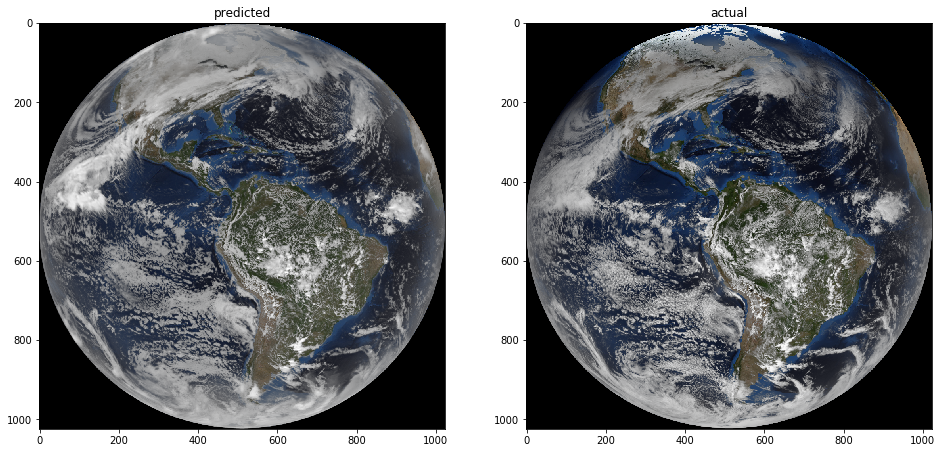

In [95]:
def show_prediction_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  raster_out_img = reader.cloud_mask(t)
  predict_img, md = predict_image(t, hparams)
  grid = reader.goes_area_definition(md)
  world_map = reader.load_world_img_from_url(BLUE_MARBLE, grid)
  world_map = world_map.astype(np.float32) / 255
 
  plt.figure(figsize=(16, 16))
  ax = plt.subplot(121)
  predict_img = predict_img[:, :, np.newaxis]
  predict_mask = 1 / (1 + np.exp(-10 * (predict_img - 0.3)))
  predict_img = predict_img * predict_mask + (1 - predict_mask) * world_map
  ax.imshow(predict_img, cmap='gray')
  plt.title('predicted')
  
  ax = plt.subplot(122)
  raster_out_img = raster_out_img.astype(np.uint8) / 256
  raster_out_img = raster_out_img[:, :, np.newaxis]
  raster_out_mask = 1 / (1 + np.exp(-10 * (raster_out_img - 0.3)))
  raster_out_img = raster_out_img * raster_out_mask + (1 - raster_out_mask) * world_map
  ax.imshow(raster_out_img, cmap='gray')
  plt.title('actual')
  plt.show()
    
show_prediction_image(datetime.datetime(2019, 1, 1, 17), hparams)

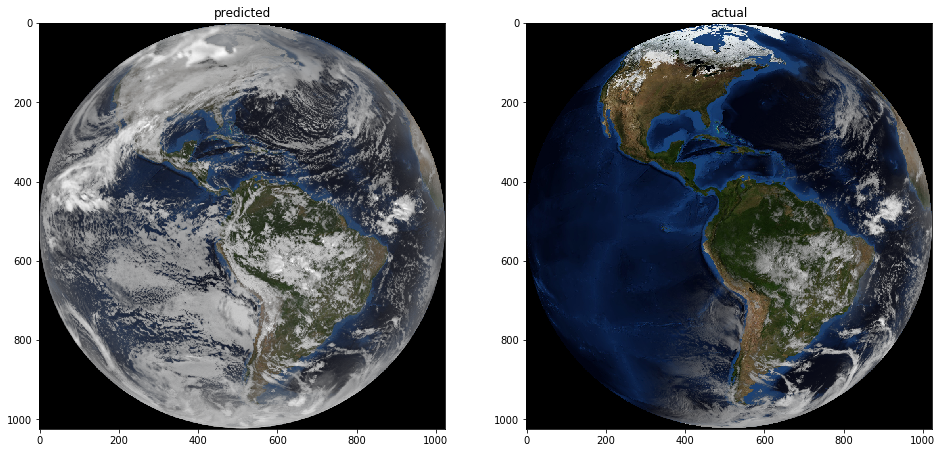

In [96]:
show_prediction_image(datetime.datetime(2019, 1, 1, 12), hparams)

In [97]:
def show_daily_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  plt.figure(figsize=(20, 32))
  for i in range(6):
    for j in range(4):
      h = i * 4 + j
      new_t = t + datetime.timedelta(hours=h)
      predict_img, md = predict_image(new_t, hparams)
      grid = reader.goes_area_definition(md)
      world_map = reader.load_world_img_from_url(BLUE_MARBLE, grid)
      world_map = world_map.astype(np.float32) / 255
      predict_img = np.maximum(0, np.minimum(1, predict_img))
      predict_img = predict_img[:, :, np.newaxis]
      predict_mask = 1 / (1 + np.exp(-10 * (predict_img - 0.3)))
      predict_img = predict_img * predict_mask + (1 - predict_mask) * world_map
      ax = plt.subplot(6, 4, h + 1)
      ax.imshow(predict_img)
      plt.title(str(new_t))
  plt.show()
    
show_daily_image(datetime.datetime(2019, 1, 1), hparams)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def get_daily_image(t: datetime.datetime, hparams: tf.contrib.training.HParams):
  imgs = []
  for i in range(6):
    for j in range(4):
      h = i * 4 + j
      new_t = t + datetime.timedelta(hours=h)
      predict_img, md = predict_image(new_t, hparams)
      grid = reader.goes_area_definition(md)
      world_map = reader.load_world_img_from_url(BLUE_MARBLE, grid)
      world_map = world_map.astype(np.float32) / 255
      predict_img = np.maximum(0, np.minimum(1, predict_img))
      predict_img = predict_img[:, :, np.newaxis]
      predict_mask = 1 / (1 + np.exp(-10 * (predict_img - 0.3)))
      predict_img = predict_img * predict_mask + (1 - predict_mask) * world_map
      predict_img = (predict_img * 255.9).astype(np.uint8)
      imgs.append(predict_img)
  return np.array(imgs)

day = get_daily_image(datetime.datetime(2019, 1, 1), hparams)

AAAAAAAA 6


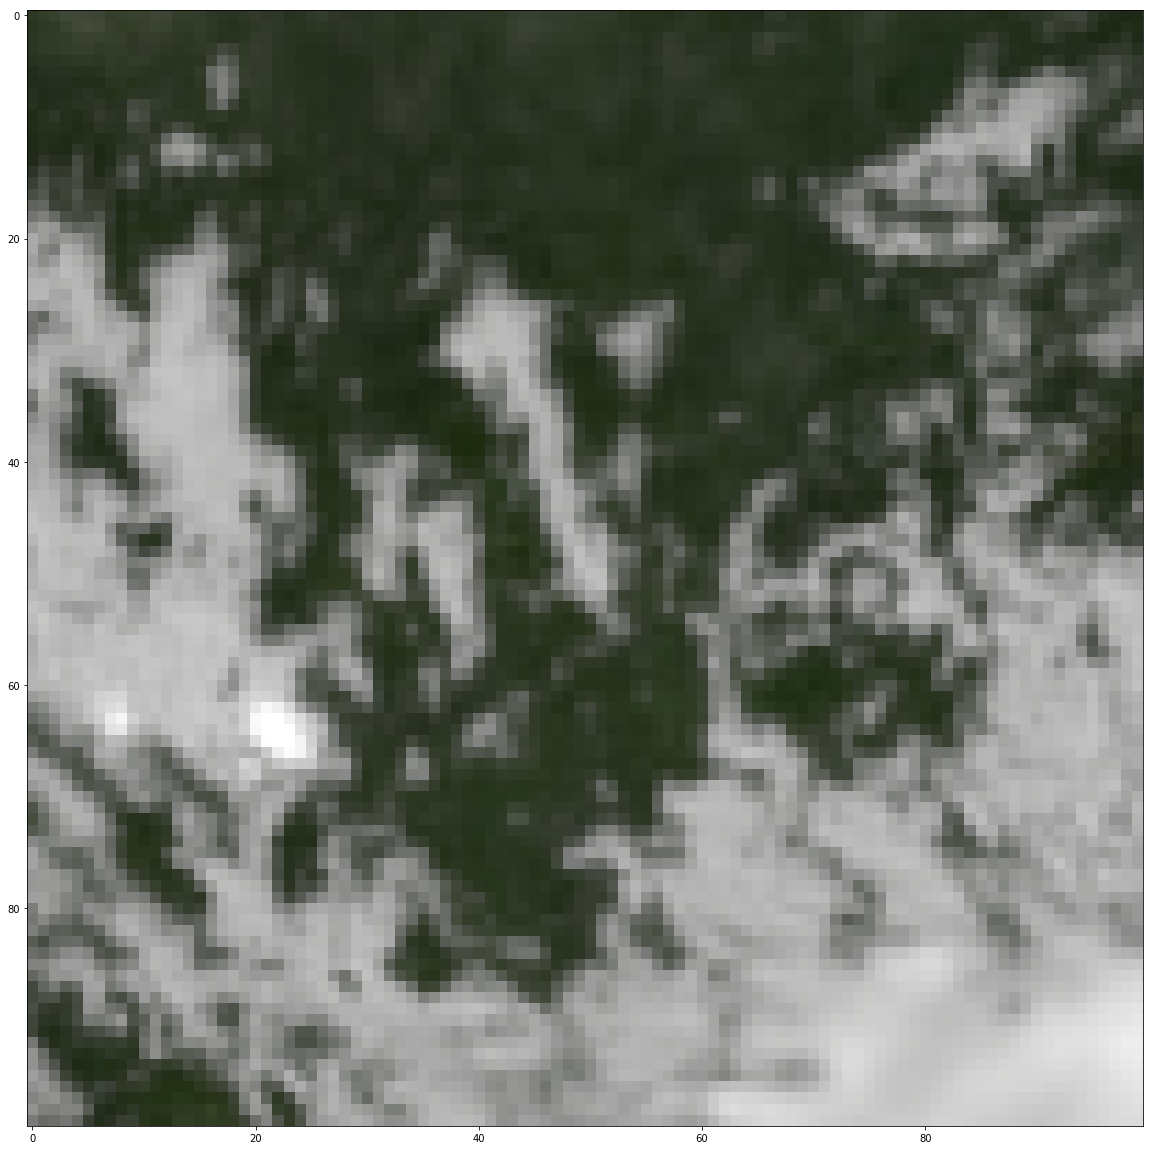

In [115]:
import matplotlib.animation as animation

def show_animated_image(day: np.ndarray):
  myday = day[:, 500:600, 500:600, :]
  fig = plt.figure(figsize=(20, 32))
  im = plt.imshow(myday[0], animated=True)  
  h = 1
  def update_fig(*args):
    global h
    print('AAAAAAAA', h)
    im.set_array(myday[h])
    h = (h + 1) % 24
    return im,
  animation.FuncAnimation(fig, update_fig, interval=1000, blit=True)
  plt.show()
    
show_animated_image(day)